# Importação de dados

Vamos utilizar o conjunto de dados do Movielens. Ele será puxado através de uma requisição (para termos os arquivos zipados sem muito esforço aqui no colab).

In [90]:
import requests, zipfile, io

def extract_zip(r):
    input_zip = zipfile.ZipFile(io.BytesIO(r.content))
    input_zip.extractall()
    return input_zip.namelist()

files = extract_zip(requests.get('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip', stream=True))

Vamos utilizar dois arquivos: o arquivo com os filmes (movies.csv)

In [91]:
import pandas as pd
filmes = pd.read_csv('ml-latest-small/movies.csv', index_col=0)
filmes.head()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


e o arquivo com as notas (ratings.csv).

In [92]:
notas = pd.read_csv('ml-latest-small/ratings.csv')
notas.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Heurística de recomendação

Quando não conhecemos nada do usuário, podemos criar heurísticas de recomendação baseada no comportamento de outros usuários. Um exemplo de heurística é a quantidade de votos; outra é a nota média de cada título. A heurística que eu criei considera esses dois aspectos ao multiplicar a nota média pela quantidade de votos. Abaixo, o top 10 de recomendações seguindo essa heurística.

In [93]:
filmes['nota_media'] = notas.groupby('movieId').mean()['rating']
filmes['qtd_votos'] = notas['movieId'].value_counts()
filmes['heuristica'] = filmes['nota_media']*filmes['qtd_votos']
filmes.sort_values(by='heuristica', ascending=False)[:10]

,title,genres,nota_media,qtd_votos,heuristica
movieId,,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317.0,1404.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.164134,329.0,1370.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068,307.0,1288.5
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278.0,1165.5
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.161290,279.0,1161.0
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076,251.0,1062.0
110,Braveheart (1995),Action|Drama|War,4.031646,237.0,955.5
2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.272936,218.0,931.5
527,Schindler's List (1993),Drama|War,4.225000,220.0,929.5


# Recomendação baseada no usuário

Quando temos conhecimento sobre o gosto do usuário, recomendar títulos fica bem mais fácil. Abaixo, meu histórico de visualização do catálogo da Netflix.

In [94]:
netflix_hist = pd.read_csv('NetflixViewingHistory (1).csv')
netflix_hist.head()

,Title,Date
0,Ano Hana: Temporada 1: Episódio 3,16/12/2021
1,Alice in Borderland: Temporada 1: Episódio 8,16/12/2021
2,Alice in Borderland: Temporada 1: Episódio 7,16/12/2021
3,Alice in Borderland: Temporada 1: Episódio 6,15/12/2021
4,Alice in Borderland: Temporada 1: Episódio 5,15/12/2021


Como juntamos apenas com os filmes, e como são catálogos diferentes, o conjunto de dados resultante é meio pequeno. Mas tudo bem.

In [95]:
filmes['chave'] = filmes['title'].apply(lambda a: a.split(' (')[0].lower())
netflix_hist['chave'] = netflix_hist['Title'].apply(lambda a: a.lower())

historico_lais = pd.merge(filmes, netflix_hist, how='left', on='chave').dropna()
historico_lais

,title,genres,nota_media,qtd_votos,heuristica,chave,Title,Date
525,Jane Eyre (1996),Drama|Romance,3.187500,8.0,25.5,jane eyre,Jane Eyre,25/01/2020
573,Boys (1996),Drama,2.000000,2.0,4.0,boys,Boys,30/08/2015
943,Manhattan (1979),Comedy|Drama|Romance,4.106061,33.0,135.5,manhattan,Manhattan,06/09/2016
1033,Carrie (1976),Drama|Fantasy|Horror|Thriller,3.347222,36.0,120.5,carrie,Carrie,20/02/2016
1177,Hercules (1997),Adventure|Animation|Children|Comedy|Musical,3.451613,31.0,107.0,hercules,Hercules,03/04/2014
1273,Anastasia (1997),Adventure|Animation|Children|Drama|Musical,3.350000,20.0,67.0,anastasia,Anastasia,03/09/2014
1390,Mulan (1998),Adventure|Animation|Children|Comedy|Drama|Musi...,3.566667,45.0,160.5,mulan,Mulan,28/01/2019
2355,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy,3.860825,97.0,374.5,toy story 2,Toy Story 2,24/07/2015
2788,Shaft (1971),Action|Crime|Drama|Thriller,4.000000,3.0,12.0,shaft,Shaft,28/09/2019
2802,Shaft (2000),Action|Crime|Thriller,2.657895,19.0,50.5,shaft,Shaft,28/09/2019


Podemos listar os gêneros mais comuns do usuário com um gráfico de barras, para entender um pouco melhor suas preferências.

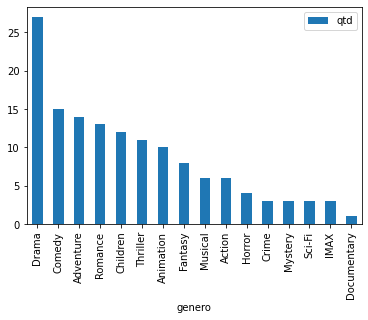

In [96]:
generos_flat = [item for sublist in historico_lais['genres'].apply(lambda a: a.split('|')) for item in sublist]

from collections import Counter
generos = pd.DataFrame(Counter(generos_flat).most_common(len(generos_flat)), columns=['genero', 'qtd'])
generos.plot.bar(x='genero')

Vemos que o usuário tem maior interesse por filmes dramáticos. Podemos, no entanto, olhar para as distribuições de "n_gramas" de gêneros, ou seja, pegar os conjuntos de gêneros que mais aparecem juntos.

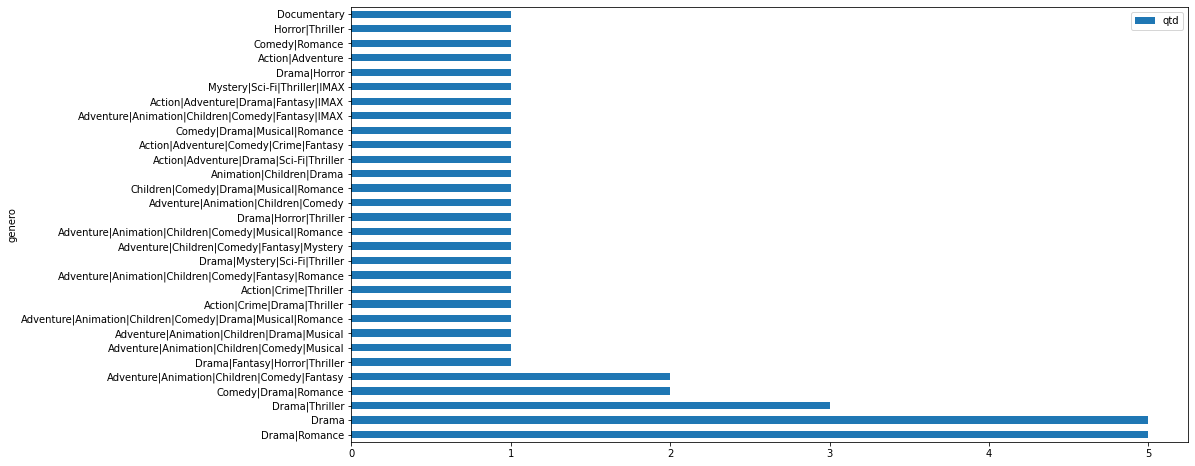

In [97]:
generos_total = pd.DataFrame(Counter(historico_lais['genres']).most_common(len(historico_lais['genres'])), columns=['genero', 'qtd'])
generos_total.plot.barh(x='genero', figsize=(15, 8))

Uma escolha popular para o usuário é Drama e Romance. Podemos também dividir por pares de 2 em 2 e de 3 em 3 gêneros, para ter um último insight antes de recomendar para este usuário.

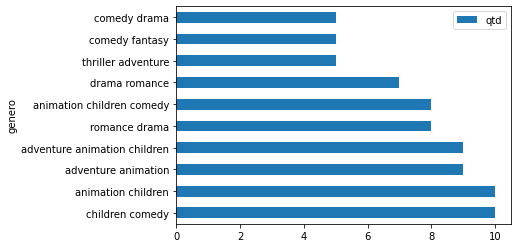

In [98]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(2,3), token_pattern=r"(?u)\b\w\w+\b")
counts = cv.fit_transform(pd.DataFrame(['|'.join(historico_lais['genres'])], columns=['texto'])['texto']).toarray().sum(axis=0)

ngram_genres = pd.DataFrame([cv.get_feature_names_out(), counts]).transpose()
ngram_genres.columns = ['genero', 'qtd']
ngram_genres.sort_values(by='qtd', ascending=False)[:10].plot.barh(x='genero')

Apesar de drama ser o gênero mais popular para o usuário, o par "children|comedy" é o que aparece com mais frequência dentre os gêneros dos filmes assistidos. O par "drama|romance" também parece ser popular. Um possível problema dessa abordagem foi que os pares "drama|romance" e "romance|drama" são considerados distintos....... depois eu arrumo.

Pudemos perceber, com nossa análise do usuário, que ele possui dois perfis de preferência: drama e romance; crianças e comédia. Com isso, podemos criar uma "regra de filtros" de gêneros para criar recomendações para este usuário. A seguir, a lista de recomendações no top 10 para o user.

In [99]:
filmes[filmes.genres.apply(lambda a: ('Drama' in a and 'Romance' in a) or ('Children' in a and 'Comedy' in a))].sort_values(by='heuristica', ascending=False)[:10]

,title,genres,nota_media,qtd_votos,heuristica,chave
movieId,,,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.164134,329.0,1370.0,forrest gump
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.920930,215.0,843.0,toy story
2858,American Beauty (1999),Drama|Romance,4.056373,204.0,827.5,american beauty
588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical,3.792350,183.0,694.0,aladdin
4306,Shrek (2001),Adventure|Animation|Children|Comedy|Fantasy|Ro...,3.867647,170.0,657.5,shrek
1704,Good Will Hunting (1997),Drama|Romance,4.078014,141.0,575.0,good will hunting
6377,Finding Nemo (2003),Adventure|Animation|Children|Comedy,3.960993,141.0,558.5,finding nemo
7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.160305,131.0,545.0,eternal sunshine of the spotless mind
4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy,3.871212,132.0,511.0,"monsters, inc."


# Collaborative filtering

Uma forma de utilizar as notas dos outros usuários é encontrar os usuários mais parecidos com o usuário alvo e recomendar os filmes que eles mais gostaram. Para isso, vamos precisar das notas do nosso usuário alvo (= eu).

In [100]:
notas_lais = [2, 3, 2, 4, 5, 4, 5, 5, 2, 2, 5, 4, 4, 3, 4, 2, 2, 5, 4, 5, 5, 5, 3, 3, 3, 3, 5, 5, 2, 4, 3, 4, 4, 4, 5, 2, 2, 4, 4, 3, 5, 2]
historico_lais['rating'] = notas_lais
historico_lais[['title', 'rating']]

,title,rating
525,Jane Eyre (1996),2
573,Boys (1996),3
943,Manhattan (1979),2
1033,Carrie (1976),4
1177,Hercules (1997),5
1273,Anastasia (1997),4
1390,Mulan (1998),5
2355,Toy Story 2 (1999),5
2788,Shaft (1971),2
2802,Shaft (2000),2


Agora, precisamos de uma função que, dados um usuário, retorne a distância entre seus ratings e os do usuário alvo.

In [101]:
import numpy as np

def dist_lais(id):
  user1 = historico_lais[['rating']]
  user2 = notas[notas.userId == id].set_index('movieId')[['rating']]
  joined_users = pd.merge(user1, user2, how='left', left_index=True, right_index=True).dropna()

  return np.inf if len(joined_users) == 0 else np.linalg.norm(joined_users['rating_x'] - joined_users['rating_y'])

dist_lais(274)

3.278719262151

E agora podemos encontrar os usuários mais parecidos comigo! \o/

In [102]:
dists = []
for id in pd.unique(notas.userId):
  dist = dist_lais(id)
  dists.append((id, dist)) if dist != np.inf else None

Abaixo, vemos que encontramos 133 usuários que viram pelo menos um filme em comum com o usuário alvo. 

In [103]:
dists_df = pd.DataFrame(dists, columns=['userId', 'dist_lais'])
dists_df['dist_lais'].describe()

count    133.000000
mean       1.854460
std        1.026580
min        0.000000
25%        1.000000
50%        2.000000
75%        2.500000
max        4.636809
Name: dist_lais, dtype: float64

Pegando apenas os 25% usuários mais próximos, ficamos com 33 usuários.

In [104]:
top25 = dists_df.sort_values(by='dist_lais')[:round(len(dists_df)/4)]
print(len(top25))

33


Agora que temos os usuários mais próximos, podemos pegar apenas os IDs dos filmes e ordená-los por nota. Esta será nossa lista de recomendações, que podemos juntar com nosso dataframe de filmes para facilitar a visualização das recomendações.

Dois pontos do código abaixo requerem atenção: primeiro, na linha 6, filtramos apenas os filmes assistidos por mais da metade dos outros usuários utilizados para fazer a recomendação. Dessa forma, evitamos recomendar filmes muito de nicho. Na linha 8, filtramos os filmes com poucos votos, novamente para prevenção de recomendações muito específicas ao usuário.

In [123]:
notas_rec = pd.merge(notas, top25, on='userId', how='right')[['rating', 'movieId']].groupby('movieId').mean()
aparicoes_rec = pd.merge(notas, top25, on='userId', how='right')[['rating', 'movieId']].groupby('movieId').count()

recomendacoes = pd.merge(notas_rec, aparicoes_rec, on='movieId')
recomendacoes.columns = ['rating', 'count']
recomendacoes = recomendacoes[recomendacoes['count'] >= (len(top25)/2)].sort_values(by='rating', ascending=False)

filmes_rec = filmes.loc[recomendacoes.index][filmes['qtd_votos'] > 50]
filmes_rec['nota_users'] = recomendacoes['rating']
filmes_rec.sort_values(by='nota_users', ascending=False)[['title', 'genres', 'nota_media', 'qtd_votos']][:10]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,title,genres,nota_media,qtd_votos
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,4.429022,317.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,4.197068,307.0
2355,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy,3.516304,92.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War,4.164134,329.0
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.231076,251.0
1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,4.137755,196.0
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,4.192446,278.0
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.161290,279.0
1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.207500,200.0


Alguns legais, alguns meio nada a ver, mas é a vida :)